In [1]:
pip install "autogen-agentchat[lmm]~=0.2"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.3/382.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.2/314.2 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.9 MB/s eta 0:00:00


In [2]:
import json
import os
import random
import time
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image
from termcolor import colored

import autogen
from autogen import Agent, AssistantAgent, ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.capabilities.vision_capability import VisionCapability
from autogen.agentchat.contrib.img_utils import get_pil_image, pil_to_data_uri
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent
from autogen.code_utils import content_str

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
# Save config to file first
import json
from dotenv import load_dotenv
load_dotenv()
api_key=os.getenv("OPENAI_API_KEY")
config = [
    {
        "model": "gpt-4-turbo",
        "api_key": api_key
    },
    {
        "model": "gpt-4",
        "api_key": api_key
    }
]
with open("OAI_CONFIG_LIST", "w") as f:
    json.dump(config, f)

# Then load from file
config_list_4v = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4-turbo","gpt-4o"],
    }
)


<a id="app-1"></a>
## Application 1: Image Chat

In this section, we present a straightforward dual-agent architecture to enable user to chat with a multimodal agent.


First, we show this image and ask a question.
![](https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0)

Within the user proxy agent, we can decide to activate the human input mode or not (for here, we use human_input_mode="NEVER" for conciseness). This allows you to interact with LMM in a multi-round dialogue, enabling you to provide feedback as the conversation unfolds.

In [7]:
from google.colab import userdata
import os

api_key = userdata.get('open_ai')
os.environ['OPENAI_API_KEY'] = api_key

In [9]:
from autogen.oai import filter_config

config_list_4v = filter_config(config, {"model": ["gpt-4-turbo"]})
config_list_gpt4 = filter_config(config, {
    "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"]
})


Learn more about configuring LLMs for agents [here](/docs/topics/llm_configuration).

In [10]:
image_agent = MultimodalConversableAgent(
    name="image-explainer",
    max_consecutive_auto_reply=10,
    llm_config={"config_list": config_list_4v, "temperature": 0.5, "max_tokens": 300},
)

user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="A human admin.",
    human_input_mode="NEVER",  # Try between ALWAYS or NEVER
    max_consecutive_auto_reply=0,
    code_execution_config={
        "use_docker": False
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
)

# Ask the question with an image
user_proxy.initiate_chat(
    image_agent,
    message="""What's the breed of this dog?
<img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.""",
)

User_proxy (to image-explainer):

What's the breed of this dog?
<image>.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
image-explainer (to User_proxy):

This adorable puppy appears to be a Goldendoodle. Goldendoodles are a crossbreed between a Golden Retriever and a Poodle, known for their friendly nature and curly, hypoallergenic coats.

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': "What's the breed of this dog?\n<img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.", 'role': 'assistant', 'name': 'User_proxy'}, {'content': 'This adorable puppy appears to be a Goldendoodle. Goldendoodles are a crossbreed between a Golden Retriever and a Poodle, known for their friendly nature and curly, hypoallergenic coats.', 'role': 'user', 'name': 'image-explainer'}], summary='This adorable puppy appears to be a Goldendoodle. Goldendoodles are a crossbreed between a Golden Retriever and a Poodle, known for their friendly nature and curly, hypoallergenic coats.', cost={'usage_including_cached_inference': {'total_cost': 0.01248, 'gpt-4-turbo-2024-04-09': {'cost': 0.01248, 'prompt_tokens': 1113, 'completion_tokens': 45, 'total_tokens': 1158}}, 'usage_excluding_cached_inference': {'total_cost': 0.01248, 'gpt-4-turbo-2024-04-09': {'cost': 0.01248, 'prompt_tokens': 1113, 'completion_t

Now, input another image, and ask a followup question.

![](https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1)

In [11]:
# Ask the question with an image
user_proxy.send(
    message="""What is this breed?
<img https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1>

Among the breeds, which one barks less?""",
    recipient=image_agent,
)

User_proxy (to image-explainer):

What is this breed?
<image>

Among the breeds, which one barks less?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
image-explainer (to User_proxy):

The dog in the image is a Siberian Husky. Siberian Huskies are known for their striking appearance, characterized by a thick double coat, erect triangular ears, and distinctive markings.

Comparing Siberian Huskies with other breeds in terms of barking, Huskies are generally known to bark less. They are more likely to howl rather than bark. Huskies are not typically "yappy" dogs and are usually quite calm in terms of vocalizations, especially when compared to breeds known for frequent barking like Chihuahuas or Beagles.

--------------------------------------------------------------------------------


<a id="app-2"></a>
## Application 2: Figure Creator

Here, we define a `FigureCreator` agent, which contains three child agents: commander, coder, and critics.

- Commander: interacts with users, runs code, and coordinates the flow between the coder and critics.
- Coder: writes code for visualization.
- Critics: LMM-based agent that provides comments and feedback on the generated image.

In [12]:
working_dir = "tmp/"

In [13]:
class FigureCreator(ConversableAgent):
    def __init__(self, n_iters=2, **kwargs):
        """
        Initializes a FigureCreator instance.

        This agent facilitates the creation of visualizations through a collaborative effort among its child agents: commander, coder, and critics.

        Parameters:
            - n_iters (int, optional): The number of "improvement" iterations to run. Defaults to 2.
            - **kwargs: keyword arguments for the parent AssistantAgent.
        """
        super().__init__(**kwargs)
        self.register_reply([Agent, None], reply_func=FigureCreator._reply_user, position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)  # noqa: F821
            raise AssertionError(error_msg)
        if messages is None:
            messages = self._oai_messages[sender]

        user_question = messages[-1]["content"]

        ### Define the agents
        commander = AssistantAgent(
            name="Commander",
            human_input_mode="NEVER",
            max_consecutive_auto_reply=10,
            system_message="Help me run the code, and tell other agents it is in the <img result.jpg> file location.",
            is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
            code_execution_config={"last_n_messages": 3, "work_dir": working_dir, "use_docker": False},
            llm_config=self.llm_config,
        )

        critics = MultimodalConversableAgent(
            name="Critics",
            system_message="""Criticize the input figure. How to replot the figure so it will be better? Find bugs and issues for the figure.
            Pay attention to the color, format, and presentation. Keep in mind of the reader-friendliness.
            If you think the figures is good enough, then simply say NO_ISSUES""",
            llm_config={"config_list": config_list_4v, "max_tokens": 300},
            human_input_mode="NEVER",
            max_consecutive_auto_reply=1,
            #     use_docker=False,
        )

        coder = AssistantAgent(
            name="Coder",
            llm_config=self.llm_config,
        )

        coder.update_system_message(
            coder.system_message
            + "ALWAYS save the figure in `result.jpg` file. Tell other agents it is in the <img result.jpg> file location."
        )

        # Data flow begins
        commander.initiate_chat(coder, message=user_question)
        img = Image.open(os.path.join(working_dir, "result.jpg"))
        plt.imshow(img)
        plt.axis("off")  # Hide the axes
        plt.show()

        for i in range(self._n_iters):
            commander.send(
                message=f"Improve <img {os.path.join(working_dir, 'result.jpg')}>",
                recipient=critics,
                request_reply=True,
            )

            feedback = commander._oai_messages[critics][-1]["content"]
            if feedback.find("NO_ISSUES") >= 0:
                break
            commander.send(
                message="Here is the feedback to your figure. Please improve! Save the result to `result.jpg`\n"
                + feedback,
                recipient=coder,
                request_reply=True,
            )
            img = Image.open(os.path.join(working_dir, "result.jpg"))
            plt.imshow(img)
            plt.axis("off")  # Hide the axes
            plt.show()

        return True, os.path.join(working_dir, "result.jpg")

In [14]:
gpt4_llm_config = {"config_list": config_list_gpt4, "cache_seed": 42}


User (to Figure Creator~):


Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.


--------------------------------------------------------------------------------
Commander (to Coder):


Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.


--------------------------------------------------------------------------------
Coder (to Commander):

Okay, we can definitely do that. Here's the plan:

1. I'm going to use the pandas library to read the data from the given URL. 

2. This data will be stored in a pandas DataFrame object, it's a two-dimensional size-mutable, potentially heterogeneous tabular data structure with labeled axes.

3. Then, using matplotlib (a popular Python data visualization library), I will plot the recorded high and low temperatures data to creat

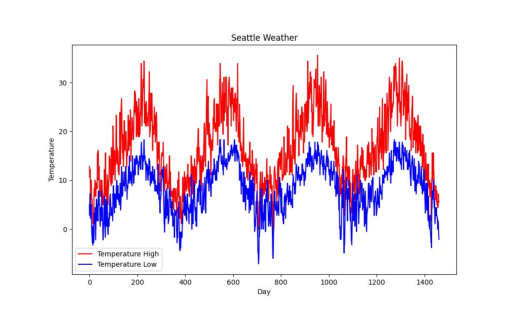

Commander (to Critics):

Improve <image>

--------------------------------------------------------------------------------
Critics (to Commander):

To improve the readability and presentation of the graph titled "Seattle Weather," consider the following suggestions:

1. **Smoothing the Data**: The lines for temperature highs and lows are very jagged, indicating daily variations. Smoothing these lines can help in identifying the overall trends more easily without losing significant data integrity.

2. **Color Contrast and Legend**: Although the red and blue colors differentiate between high and low temperatures, using more contrasting colors or varying the line styles (like dash or dot patterns) could help those with color vision deficiencies. Additionally, ensure the legend is clearly visible and distinct.

3. **Adding Gridlines**: Light horizontal and vertical gridlines would make it easier to read specific values off the graph.

4. **Labeling the Axis More Descriptively**: The x-axis

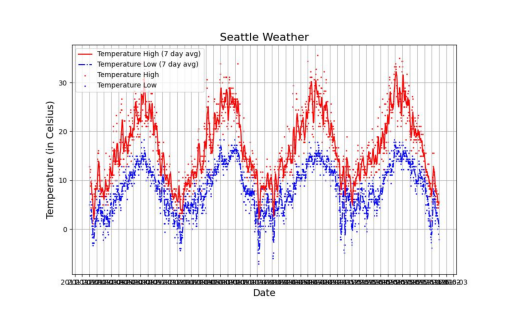

Commander (to Critics):

Improve <image>

--------------------------------------------------------------------------------
Commander (to Coder):

Here is the feedback to your figure. Please improve! Save the result to `result.jpg`
Improve <img tmp/result.jpg>

--------------------------------------------------------------------------------
Coder (to Commander):

I'm sorry, but without specific feedback on what to improve in the figure, I can't provide a solution. Could you please describe what you want to change or improve in the figure? For instance, are there any specific elements such as labels, legends, colors, or the level of data smoothing that you wish to adjust? This will assist me in providing an accurate solution.

--------------------------------------------------------------------------------
Commander (to Coder):

I'm sorry, but I can't assist with that.

--------------------------------------------------------------------------------
Coder (to Commander):

That's okay. If

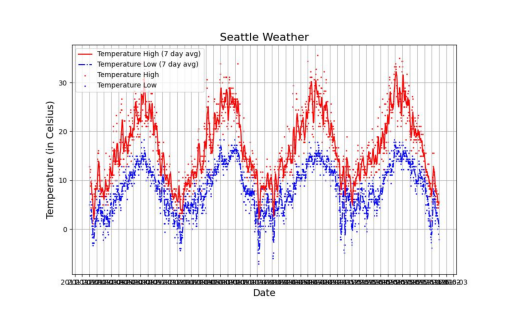

Figure Creator~ (to User):

tmp/result.jpg

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': '\nPlot a figure by using the data from:\nhttps://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv\n\nI want to show both temperature high and low.\n', 'role': 'assistant', 'name': 'User'}, {'content': 'tmp/result.jpg', 'role': 'user', 'name': 'Figure Creator~'}], summary='tmp/result.jpg', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

In [15]:
creator = FigureCreator(name="Figure Creator~", llm_config=gpt4_llm_config)

user_proxy = autogen.UserProxyAgent(
    name="User", human_input_mode="NEVER", max_consecutive_auto_reply=0, code_execution_config={"use_docker": False}
)

user_proxy.initiate_chat(
    creator,
    message="""
Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.
""",
)

## Vision Capability: Group Chat Example with Multimodal Agent

We recommend using VisionCapability for group chat managers so that it can organize and understand images better.

In [16]:
agent1 = MultimodalConversableAgent(
    name="image-explainer-1",
    max_consecutive_auto_reply=10,
    llm_config={"config_list": config_list_4v, "temperature": 0.5, "max_tokens": 300},
    system_message="Your image description is poetic and engaging.",
)
agent2 = MultimodalConversableAgent(
    name="image-explainer-2",
    max_consecutive_auto_reply=10,
    llm_config={"config_list": config_list_4v, "temperature": 0.5, "max_tokens": 300},
    system_message="Your image description is factual and to the point.",
)

user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="Desribe image for me.",
    human_input_mode="TERMINATE",  # Try between ALWAYS, NEVER, and TERMINATE
    max_consecutive_auto_reply=10,
    code_execution_config={
        "use_docker": False
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
)

# We set max_round to 5
groupchat = autogen.GroupChat(agents=[agent1, agent2, user_proxy], messages=[], max_round=5)

vision_capability = VisionCapability(lmm_config={"config_list": config_list_4v, "temperature": 0.5, "max_tokens": 300})
group_chat_manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=gpt4_llm_config)
vision_capability.add_to_agent(group_chat_manager)

rst = user_proxy.initiate_chat(
    group_chat_manager,
    message="""Write a poet for my image:
                        <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.""",
)

User_proxy (to chat_manager):

Write a poet for my image:
                        <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.

--------------------------------------------------------------------------------

Next speaker: image-explainer-1


>>>>>>>> USING AUTO REPLY...
image-explainer-1 (to chat_manager):

In a cozy corner of a well-loved home,
Lies Weston, a poodle with curls like the foam
Of a gentle sea, soft and apricot-hued,
In his eyes, the spark of puppyhood's prelude.

With a collar as vibrant as a summer's day kite,
Weston gazes up, his eyes shining bright.
A tag that twinkles, bearing his name,
In a world brand new, he's ready to claim.

Behind him, guardians of the rainy day walks,
Black boots stand silent, as if they could talk
Of puddles jumped and raindrops caught,
Of the joyous laughter and the peace they brought.

Here in this threshold, where adventures begin,
Weston's journey unfolds, a tale written in grin

## Behavior with and without VisionCapability for Agents


Here, we show the behavior of an agent with and without VisionCapability. We use the same image and question as in the previous example.

In [17]:
agent_no_vision = AssistantAgent(name="Regular LLM Agent", llm_config=gpt4_llm_config)

agent_with_vision = AssistantAgent(name="Regular LLM Agent with Vision Capability", llm_config=gpt4_llm_config)
vision_capability = VisionCapability(lmm_config={"config_list": config_list_4v, "temperature": 0.5, "max_tokens": 300})
vision_capability.add_to_agent(agent_with_vision)


user = UserProxyAgent(
    name="User",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=0,
    code_execution_config={"use_docker": False},
)

message = """Write a poet for my image:
                        <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>."""

In [18]:
user.send(message=message, recipient=agent_no_vision, request_reply=True)

User (to Regular LLM Agent):

Write a poet for my image:
                        <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.

--------------------------------------------------------------------------------
Regular LLM Agent (to User):

As an AI text-based model, I have no visual perception capability and I can't access the internet. So, unfortunately, I'm unable to see the image you referred to or write a poem specifically for it. However, I can provide a general poem in response to an assumed theme. Let's say, a scenic view. Here is a poem for you:

Beneath the sky so vast and blue,
Lies a world radiant like morning dew. 
Visions of splendor, nature's art,
Scenes so serene they captivate the heart.

From mountains high to oceans deep,
In each corner, memories to keep.
The whispering winds, the babbling brook,
Open your eyes, just pause and look.

A world painted with details fine,
A masterstroke from the hand divine.
Every m

In [19]:
user.send(message=message, recipient=agent_with_vision, request_reply=True)

User (to Regular LLM Agent with Vision Capability):

Write a poet for my image:
                        <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.

--------------------------------------------------------------------------------
Regular LLM Agent with Vision Capability (to User):

In soft hues of apricot delight, draped in curls so poodle-tight,
Upon the canvas white and bright, lies innocence in tender light.
The gaze so pure, the eyes so deep, love conveyed in bounds and leaps.

Your name, dear Weston, shines with grace, on collar's rainbow embrace.
It circles round your fluffy form, a beacon in the storm.
With bone-shaped tag, upon your neck, love declared in every speck.
  
In backdrop, boots of black stand tall, witnessing love's kindly call.
Setting suggests an entryway, where paw and boot in friendship play,
Tales of mud, of rain, and fun, unveiled under the homely sun.

Reminding all of simpler times, your image sings

## Custom Caption Function for Vision Capability

In many use cases, we can use a custom function within the Vision Capability to transcribe an image into a caption.

For instance, we can use rule-based algorithm or other models to detect the color, box, and other components inside the image.

The custom model should take a path to the image and return a string caption.

In the example below, the Vision Capability will call LMM to get caption and also call the custom function to get more information.

In [20]:
def my_description(image_url: str, image_data: Image = None, lmm_client: object = None) -> str:
    """
    This function takes an image URL and returns the description.

    Parameters:
        - image_url (str): The URL of the image.
        - image_data (PIL.Image): The image data.
        - lmm_client (object): The LLM client object.

    Returns:
        - str: A description of the color of the image.
    """
    # Print the arguments for illustration purpose
    print("image_url", image_url)
    print("image_data", image_data)
    print("lmm_client", lmm_client)

    img_uri = pil_to_data_uri(image_data)  # cast data into URI (str) format for API call
    lmm_out = lmm_client.create(
        context=None,
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Describe this image in 10 words."},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": img_uri,
                        },
                    },
                ],
            }
        ],
    )
    description = lmm_out.choices[0].message.content
    description = content_str(description)

    # Convert the image into an array of pixels.
    pixels = np.array(image_data)

    # Calculate the average color.
    avg_color_per_row = np.mean(pixels, axis=0)
    avg_color = np.mean(avg_color_per_row, axis=0)
    avg_color = avg_color.astype(int)  # Convert to integer for color values

    # Format the average color as a string description.
    caption = f"""The image is from {image_url}
    It is about: {description}
    The average color of the image is RGB:
        ({avg_color[0]}, {avg_color[1]}, {avg_color[2]})"""

    print(caption)  # For illustration purpose

    return caption

In [21]:
agent_with_vision_and_func = AssistantAgent(
    name="Regular LLM Agent with Custom Func and LMM", llm_config=gpt4_llm_config
)

vision_capability_with_func = VisionCapability(
    lmm_config={"config_list": config_list_4v, "temperature": 0.5, "max_tokens": 300},
    custom_caption_func=my_description,
)
vision_capability_with_func.add_to_agent(agent_with_vision_and_func)

user.send(message=message, recipient=agent_with_vision_and_func, request_reply=True)

User (to Regular LLM Agent with Custom Func and LMM):

Write a poet for my image:
                        <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.

--------------------------------------------------------------------------------
image_url https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0
image_data <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7E08C6CE32B0>
lmm_client <autogen.oai.client.OpenAIWrapper object at 0x7e08c6ce02e0>
The image is from https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0
    It is about: Cute curly-haired puppy wearing a colorful collar indoors.
    The average color of the image is RGB:
        (170, 155, 137)
Regular LLM Agent with Custom Func and LMM (to User):

Born in a world so fine and wide,
A creature of love, where heart resides,
Cute curly-haired puppy, stepping inside,
Colorful shades in its 